# Exploratory Data Analysis (EDA) - Cars Dataset

In [1]:
import os
import sys  
from pathlib import Path
curr_path = str(Path(os.getcwd()).parent)
sys.path.append(curr_path)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import us

from pyspark.sql.functions import isnan, when, count, col, lit, udf, month, year, to_date
from pyspark.sql.types import StringType
from datetime import datetime

from scripts.constants import *
from scripts.plotting import *



In [2]:
# Create a spark session
spark = create_spark()

24/04/27 18:41:38 WARN Utils: Your hostname, Ees-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 100.95.229.59 instead (on interface en0)
24/04/27 18:41:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/27 18:41:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Loading Dataset and Exploring Initial Data

In [3]:
# Read in cars dataset
cars = spark.read.csv("../landing/car_prices.csv", header = True, inferSchema = True)
cars.show(5)

+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|year| make|              model|      trim| body|transmission|              vin|state|condition|odometer|color|interior|              seller|  mmr|sellingprice|            saledate|
+----+-----+-------------------+----------+-----+------------+-----------------+-----+---------+--------+-----+--------+--------------------+-----+------------+--------------------+
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg566472|   ca|        5|   16639|white|   black|kia motors americ...|20500|       21500|Tue Dec 16 2014 1...|
|2015|  Kia|            Sorento|        LX|  SUV|   automatic|5xyktca69fg561319|   ca|        5|    9393|white|   beige|kia motors americ...|20800|       21500|Tue Dec 16 2014 1...|
|2014|  BMW|           3 Series|328i SULEV|Sedan|   automatic|wba3c1c51ek116351|   ca|    

In [4]:
cars.printSchema()

root
 |-- year: integer (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- trim: string (nullable = true)
 |-- body: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- vin: string (nullable = true)
 |-- state: string (nullable = true)
 |-- condition: integer (nullable = true)
 |-- odometer: integer (nullable = true)
 |-- color: string (nullable = true)
 |-- interior: string (nullable = true)
 |-- seller: string (nullable = true)
 |-- mmr: integer (nullable = true)
 |-- sellingprice: integer (nullable = true)
 |-- saledate: string (nullable = true)



In [5]:
# Number of rows (observations)
cars.count()

558837

## Data Cleaning

In [6]:
# Checking for missing values
missing_values = cars.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cars.columns])

# Calculate the total number of rows in the dataset
total_rows = cars.count()

# Calculate the percentage of missing values for each column
missing_percentages = missing_values.select([(col(c) / total_rows * 100).alias(c + "_percentage") for c in cars.columns])

# Display the combined result
missing_percentages.show()

+---------------+------------------+-----------------+------------------+-----------------+-----------------------+-------------------+----------------+--------------------+--------------------+-------------------+-------------------+-----------------+--------------------+-----------------------+--------------------+
|year_percentage|   make_percentage| model_percentage|   trim_percentage|  body_percentage|transmission_percentage|     vin_percentage|state_percentage|condition_percentage| odometer_percentage|   color_percentage|interior_percentage|seller_percentage|      mmr_percentage|sellingprice_percentage| saledate_percentage|
+---------------+------------------+-----------------+------------------+-----------------+-----------------------+-------------------+----------------+--------------------+--------------------+-------------------+-------------------+-----------------+--------------------+-----------------------+--------------------+
|            0.0|1.8432924090566658|1.86082

Columns with missing values:
- make      
- model       
- trim         
- body            
- transmission    (largest percentage of missing values)
- vin (only have 4 rows of missing values)            
- condition     
- odometer         
- color            
- interior          
- mmr                
- sellingprice       
- saledate           

In [7]:
# List of columns that has missing values 
columns_with_missing_values = ['make', 'model', 'trim', 'body', 'vin', 'condition', 'odometer', 'color', 'interior', 'mmr', 'sellingprice', 'saledate']

# Drop rows for certain columns given the small percentage of missing values
cleaned_cars_df = cars.dropna(subset=columns_with_missing_values)

# Filling missing values in the 'transmission' column with 'unknown'
cleaned_cars_df = cleaned_cars_df.fillna({'transmission': 'unknown'})

# Checking the count of missing values after cleaning
cleaned_missing_values = cleaned_cars_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cleaned_cars_df.columns])
cleaned_missing_values.show()

# Dropping duplicates if any
cars_df = cleaned_cars_df.dropDuplicates()

print("Number of rows removed after data cleaning:", total_rows - cars_df.count())
print("Number of rows after after data cleaning:", cars_df.count())



24/04/27 18:41:53 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|year|make|model|trim|body|transmission|vin|state|condition|odometer|color|interior|seller|mmr|sellingprice|saledate|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+
|   0|   0|    0|   0|   0|           0|  0|    0|        0|       0|    0|       0|     0|  0|           0|       0|
+----+----+-----+----+----+------------+---+-----+---------+--------+-----+--------+------+---+------------+--------+



Number of rows removed after data cleaning: 25189


Number of rows after after data cleaning: 533648


### => Convert state code into state names
- Easier for analysis 

In [8]:
# Define a UDF to convert state codes to state names
@udf(StringType())
def code_to_state_name(code):
    try:
        return us.states.lookup(code.lower()).name
    except AttributeError:
        return "Unknown"

# Apply the UDF to create a new column with the state names
cars_df = cars_df.withColumn("state_name", code_to_state_name(cars_df["state"]))

# Filter the DataFrame to select rows where state_name is "Unknown"
unknown_states_count = cars_df.filter(col("state_name") == "Unknown").count()

# Show the DataFrame with unknown state names
print("Number of rows with unknown state names:", unknown_states_count)


Number of rows with unknown state names: 4650


There are 4650 rows with unknown states name.

In [9]:
# Filter the DataFrame to select rows where state_name is "Unknown"
unknown_states_df = cars_df.filter(col("state_name") == "Unknown")

# Get all unique values for the "state" column in unknown_states_df
unique_states = unknown_states_df.select("state").distinct().collect()

# Extract the unique state values from the result
unique_state_values = [row.state for row in unique_states]

# Print the unique state values
print("Unique state code with unknown state name:")
for state in unique_state_values:
    print(state)

Unique state code with unknown state name:
on
ab
qc
ns


Manually checking this:
- 'ab': not a valid US state code
- 'on': seems to represent the province of Ontario in Canada, rather than a state in the United States.
- 'qc': typically represents the province of Quebec in Canada, rather than a state in the United States.
- 'ns': typically represents the province of Nova Scotia in Canada, rather than a state in the United States. 

Here, we decided to drop the rows that corresponds to the "Unknown" value in state name as it is not a valid US code. Instead they are provinces in Canada which is not relevant to our analysis.

In [10]:

# Drop rows with state_name = 'Unknown'
cars_df = cars_df.filter(cars_df["state_name"] != 'Unknown')

# Number of rows
cars_df.count()

528998

In [11]:
from pyspark.sql.functions import substring

# Extract sale month and sale year from the saledate column
cars_df_test = cars_df.withColumn("sale_month", substring("saledate", 5, 3))
cars_df_test = cars_df.withColumn("sale_year", substring("saledate", -4, 4))

# Show the DataFrame with the new sale_month and sale_year columns
cars_df_test.show()

+----+-------------+-------------+---------+---------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+----------+---------+
|year|         make|        model|     trim|     body|transmission|              vin|state|condition|odometer| color|interior|              seller|  mmr|sellingprice|            saledate|state_name|sale_year|
+----+-------------+-------------+---------+---------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+--------------------+----------+---------+
|2015|        Volvo|         XC70|       T6|    Wagon|   automatic|yv4902nb3f1198103|   ca|       42|   16506| brown|   brown|volvo na rep/worl...|32100|       32500|Thu Feb 26 2015 0...|California|     PST)|
|2013|      Hyundai|Sonata Hybrid|  Limited|    Sedan|   automatic|kmhec4a41da089739|   ca|       47|    8595|silver|    gray|hyundai motor ame...|19100|       1850

In [12]:
# Define a function to parse the date string
def parse_date(date_str):
    # Example date string: Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
    # Split the date string and extract the relevant parts
    parts = date_str.split()
    month_str = parts[1]
    day = parts[2]
    year = parts[3]
    
    # Map month names to their corresponding numbers
    month_map = {
        'Jan': '01',
        'Feb': '02',
        'Mar': '03',
        'Apr': '04',
        'May': '05',
        'Jun': '06',
        'Jul': '07',
        'Aug': '08',
        'Sep': '09',
        'Oct': '10',
        'Nov': '11',
        'Dec': '12'
    }
    
    # Format the date string as YYYY-MM-DD
    formatted_date = f"{year}-{month_map[month_str]}-{day}"
    
    return formatted_date

# Define the UDF to apply the parse_date function
parse_date_udf = udf(parse_date)

# Apply the UDF to the saledate column to parse the date string
cars_df = cars_df.withColumn("saledate", parse_date_udf(cars_df["saledate"]))

# Convert the saledate column to a DateType column
cars_df = cars_df.withColumn("saledate", to_date(cars_df["saledate"]))

# Extract sale month and sale year from the saledate column
cars_df = cars_df.withColumn("sale_month", month("saledate"))
cars_df = cars_df.withColumn("sale_year", year("saledate"))

# Show the DataFrame with the new sale_month and sale_year columns
cars_df.show()


+----+-------------+-------------+---------+---------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+----------+----------+----------+---------+
|year|         make|        model|     trim|     body|transmission|              vin|state|condition|odometer| color|interior|              seller|  mmr|sellingprice|  saledate|state_name|sale_month|sale_year|
+----+-------------+-------------+---------+---------+------------+-----------------+-----+---------+--------+------+--------+--------------------+-----+------------+----------+----------+----------+---------+
|2015|        Volvo|         XC70|       T6|    Wagon|   automatic|yv4902nb3f1198103|   ca|       42|   16506| brown|   brown|volvo na rep/worl...|32100|       32500|2015-02-26|California|         2|     2015|
|2013|      Hyundai|Sonata Hybrid|  Limited|    Sedan|   automatic|kmhec4a41da089739|   ca|       47|    8595|silver|    gray|hyundai motor ame...|19100|       

In [13]:
cars_df.count()

528998

In [14]:

cars_df_pd = cars_df.toPandas()

In [15]:
# Write the clean data set into curated layer
cars_df_pd.to_csv("../curated/car_prices_curated.csv")

## Exploratory Data Analysis (EDA)

### => Categorical Features

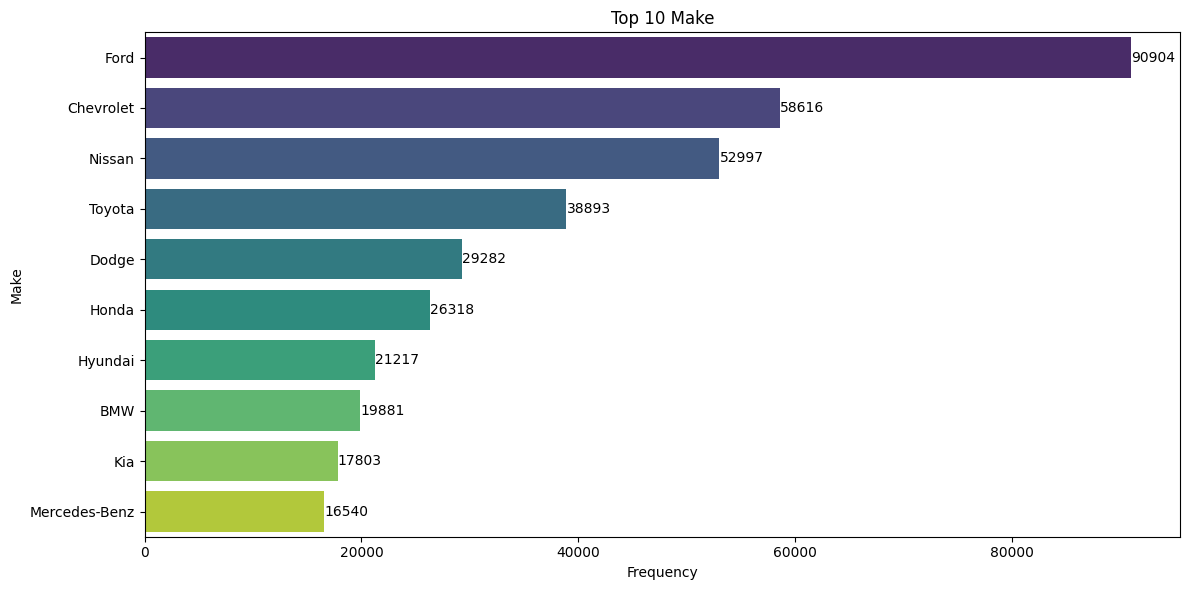

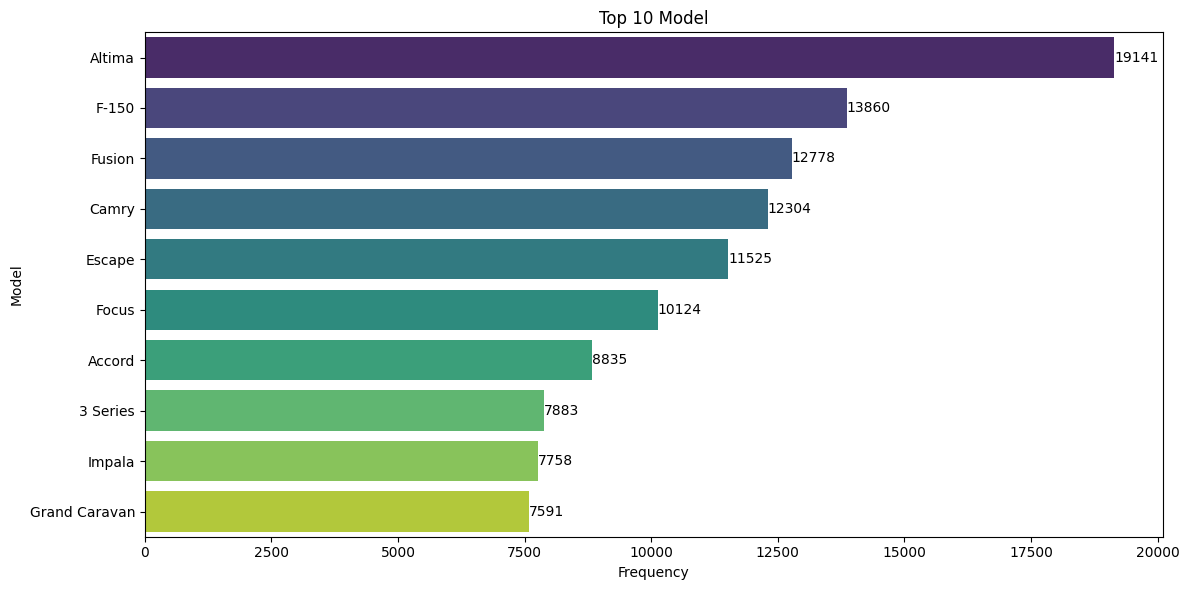

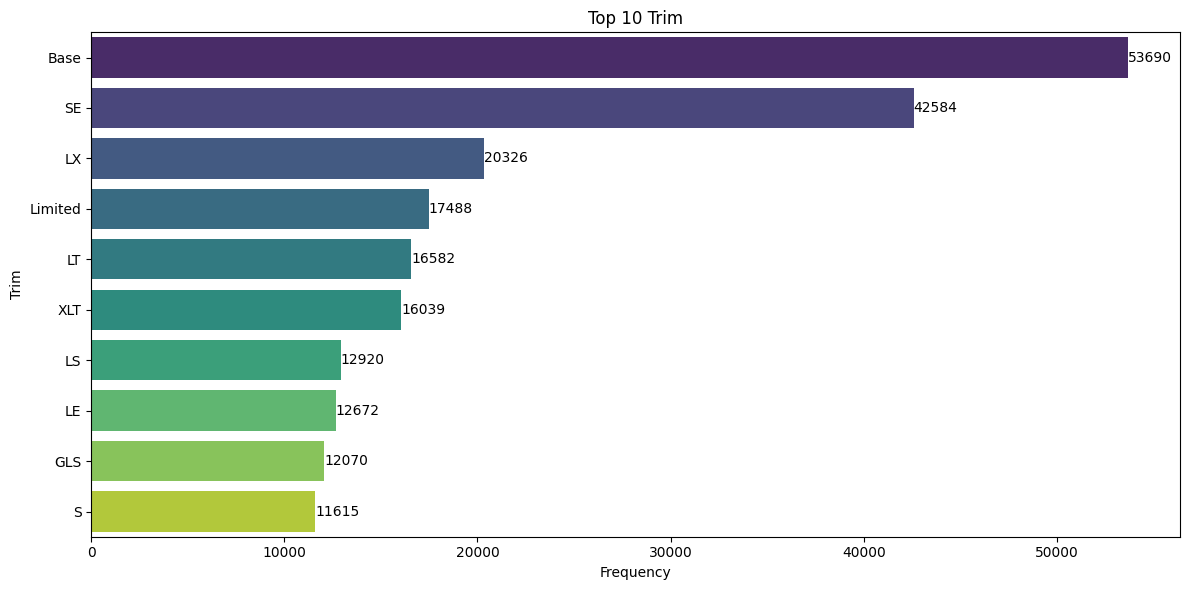

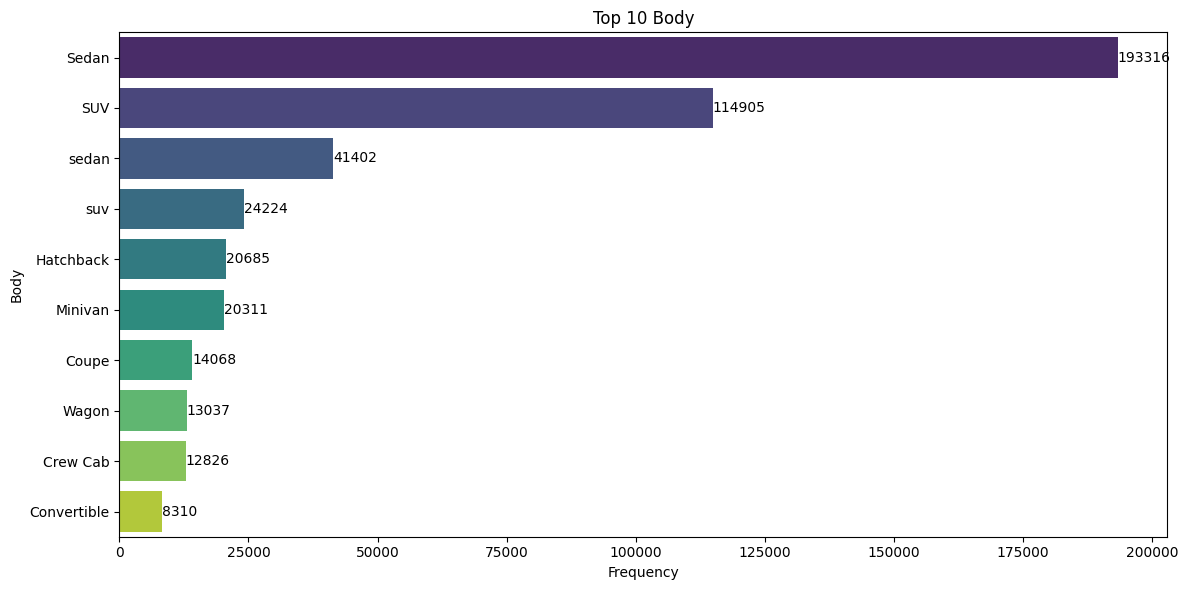

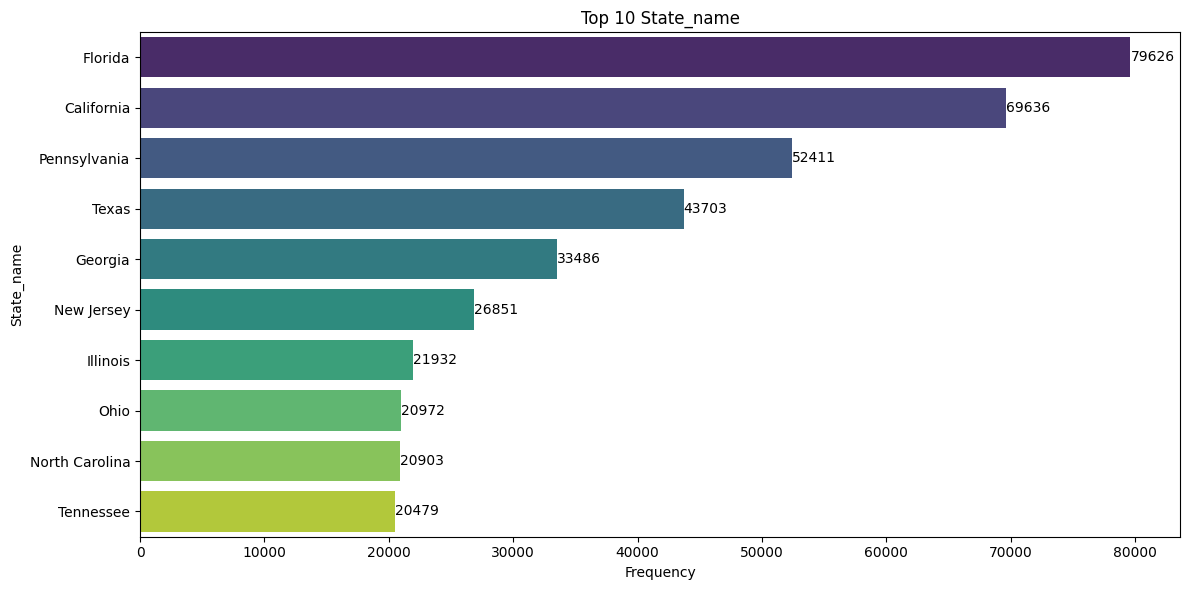

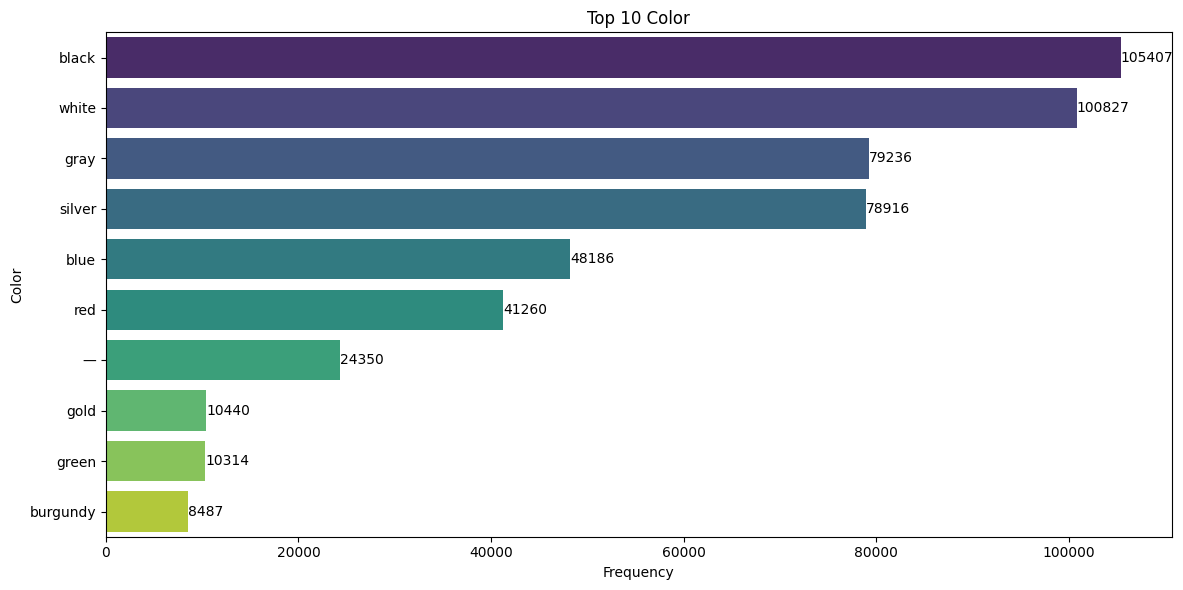

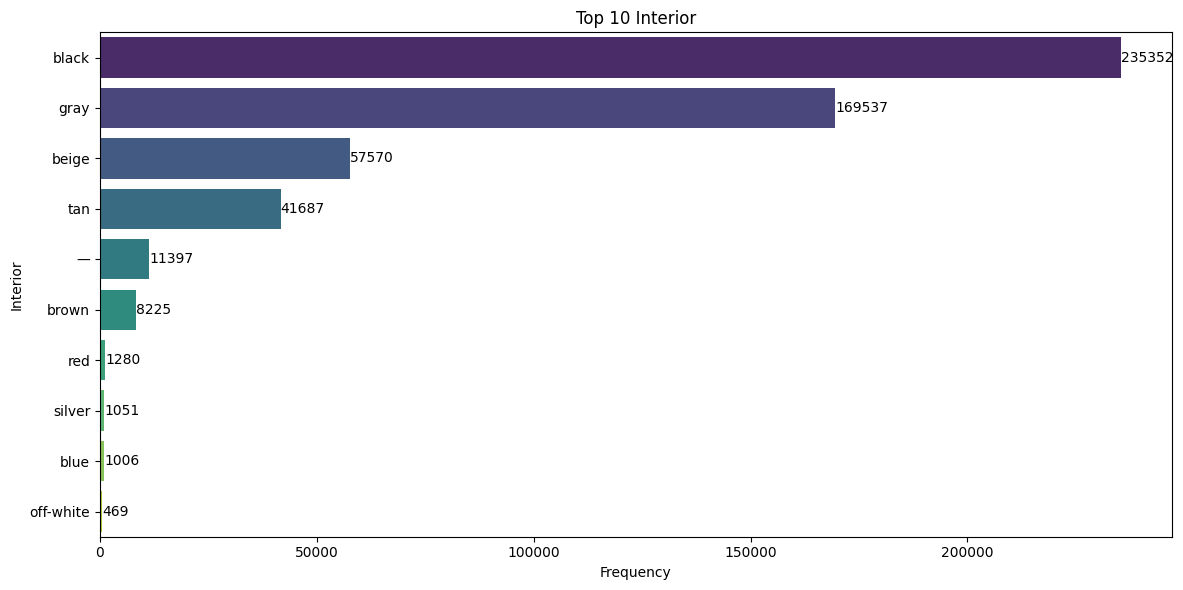

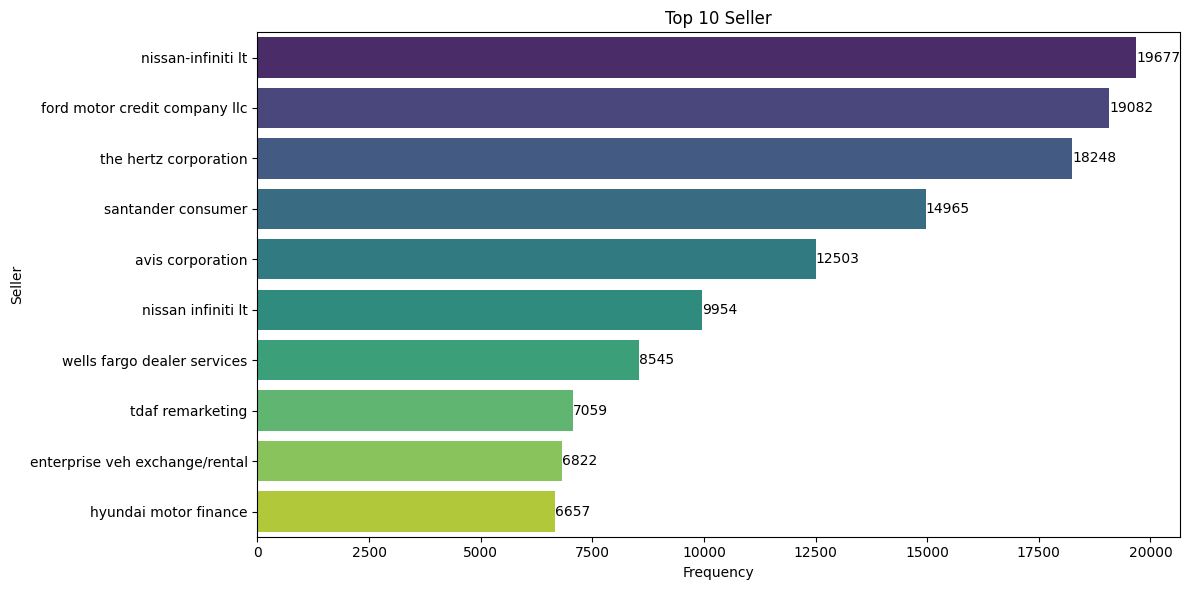

In [16]:
features_to_plot = ['make', 'model', 'trim', 'body', 'state_name', 'color', 'interior', 'seller']

# Plot the top 10 values for these columns
for col in features_to_plot:
    plot_top_values(cars_df, col, top_n = 10)

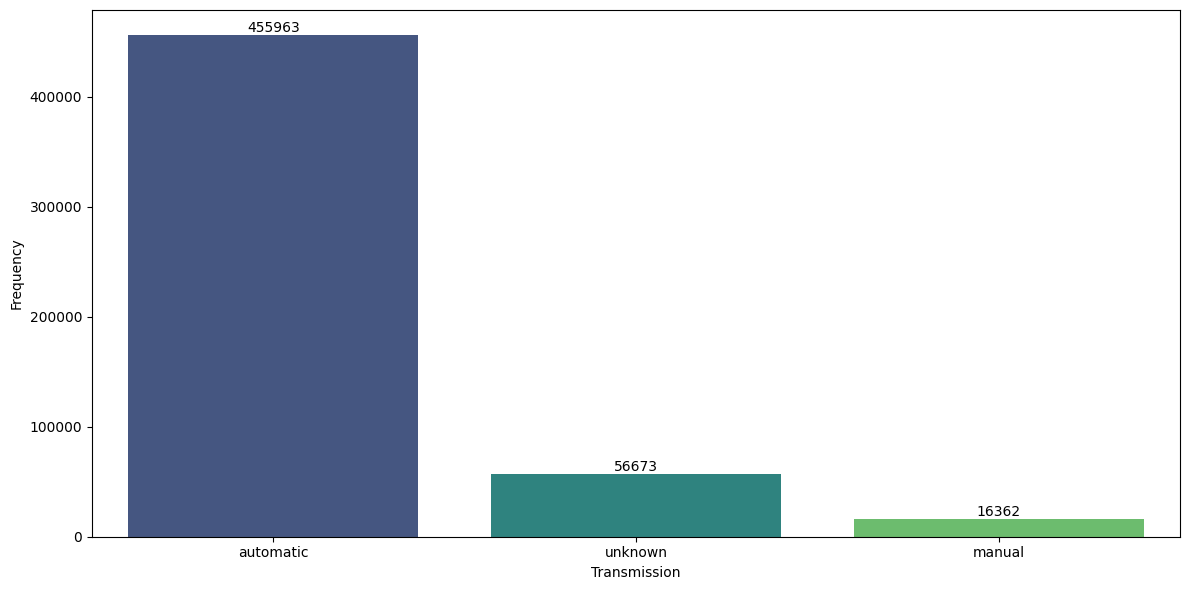

In [17]:
# Plot barplot for transmission
plot_vertical_barplot(cars_df, 'transmission')

### => Numeric Features

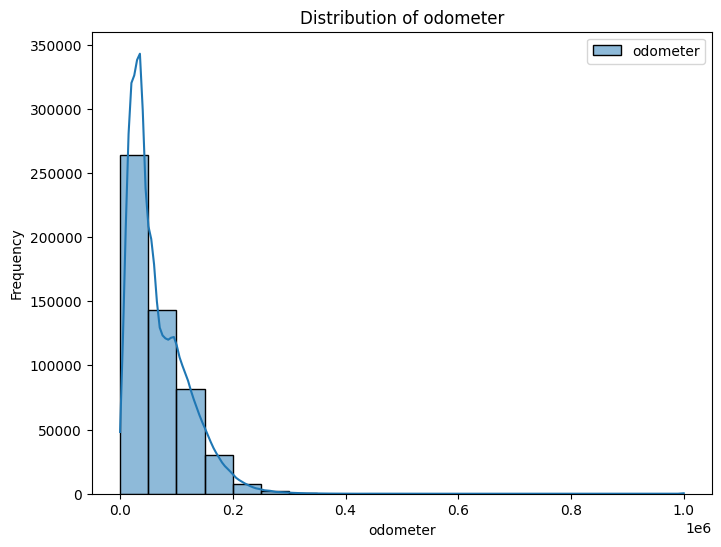

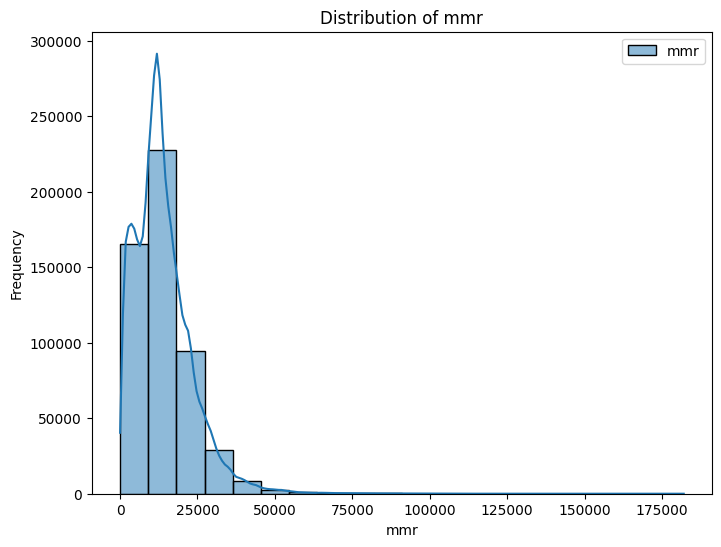

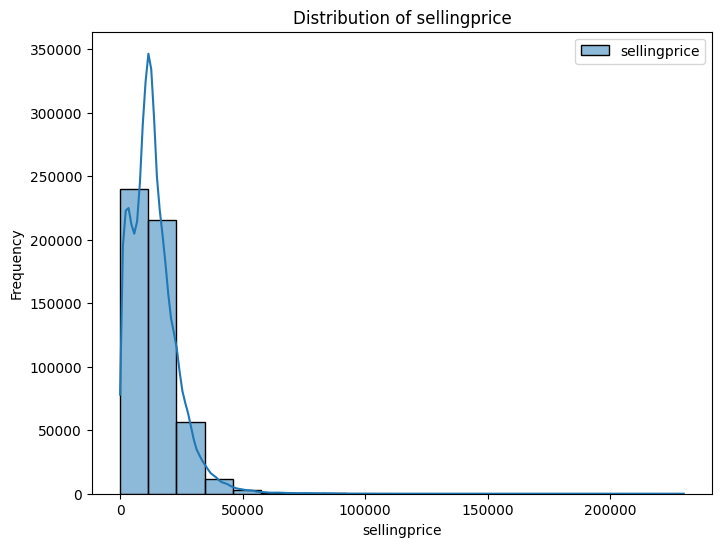

In [18]:
# Histograms of numeric features
numeric_features = ['odometer', 'mmr', 'sellingprice']
for feature in numeric_features:
    plot_histogram(cars_df, feature)

### => Others

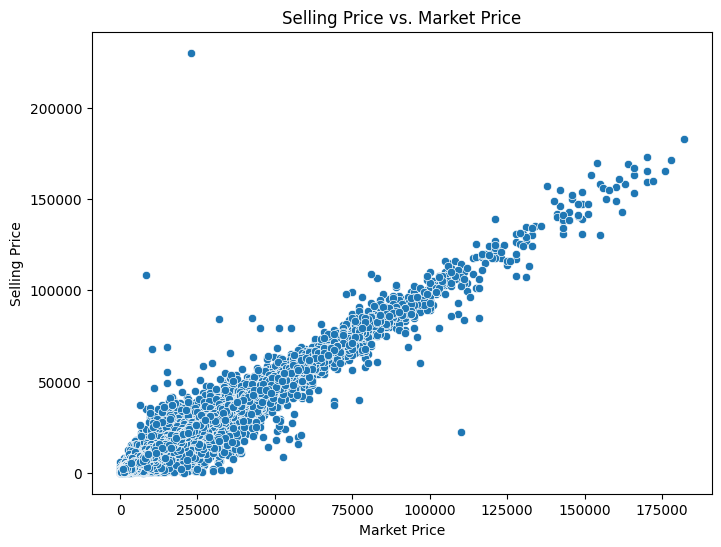

In [19]:
# Explore the relationship between the selling price and market price
plt.figure(figsize=(8, 6))
sns.scatterplot(x="mmr", y="sellingprice", data=cars_df.toPandas())
plt.title('Selling Price vs. Market Price')
plt.xlabel('Market Price')
plt.ylabel('Selling Price')
plt.show()


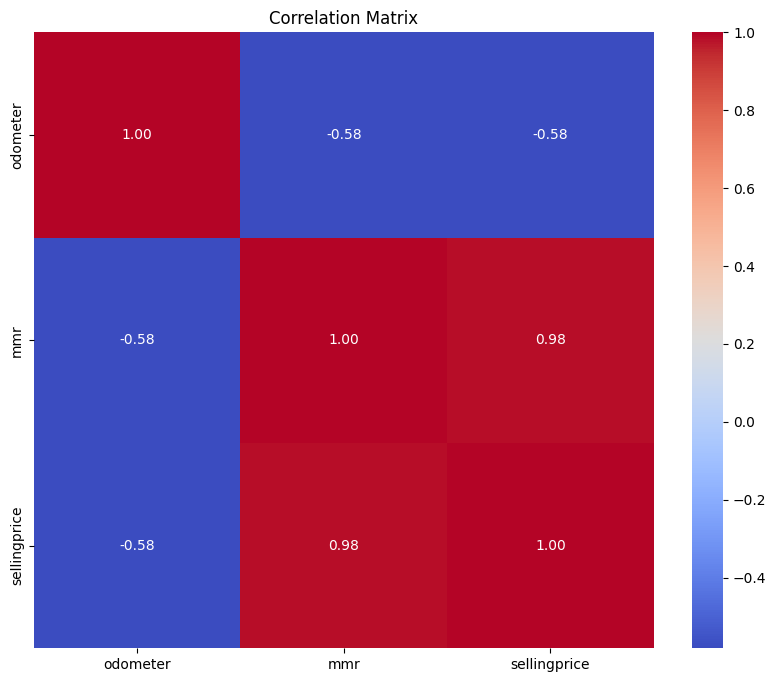

In [20]:
# Heatmap of Correlations
numeric_cols = ['odometer', 'mmr', 'sellingprice']
correlation_matrix = cars_df.select(numeric_cols).toPandas().corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

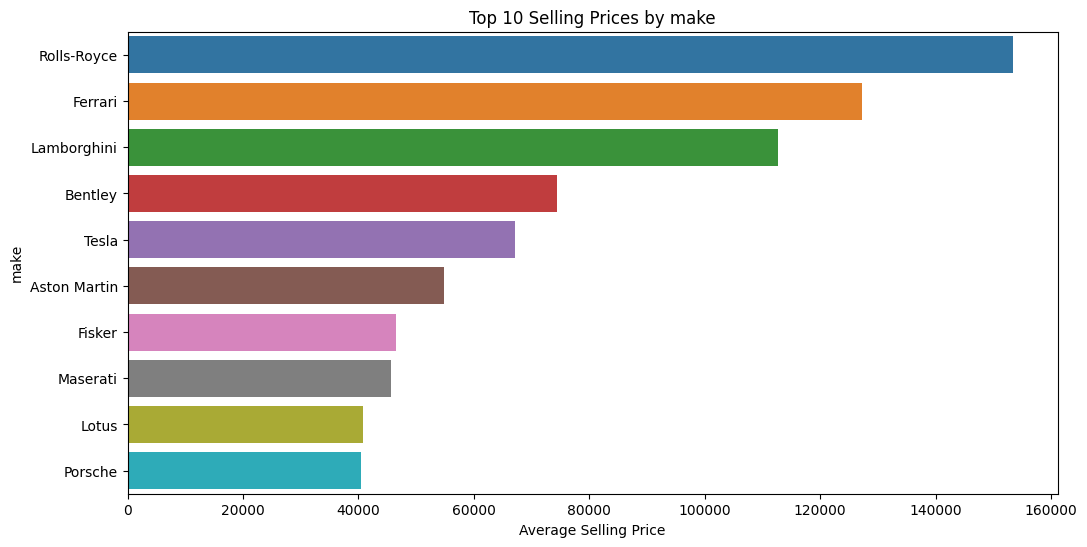

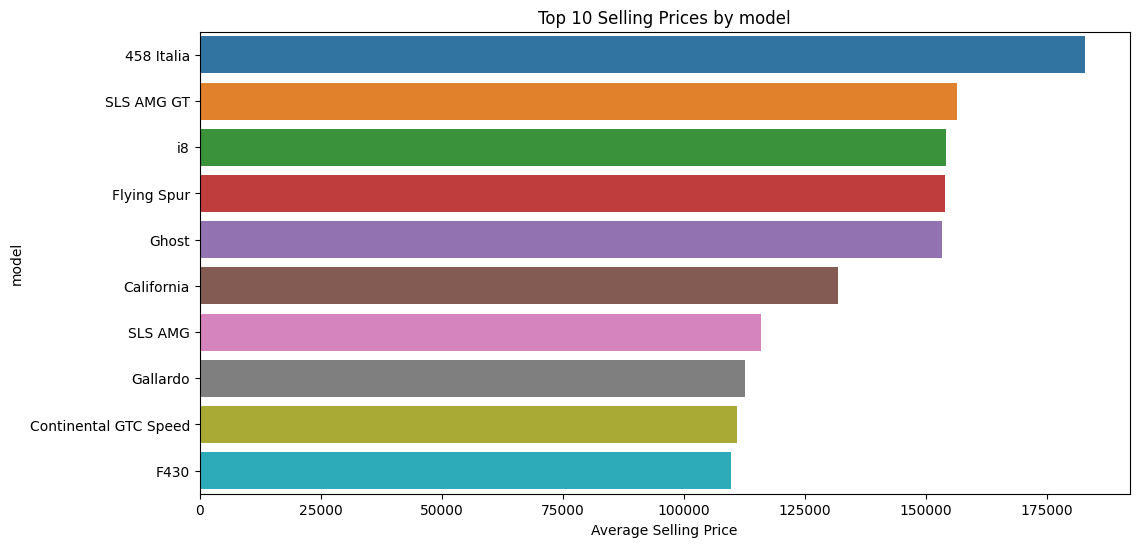

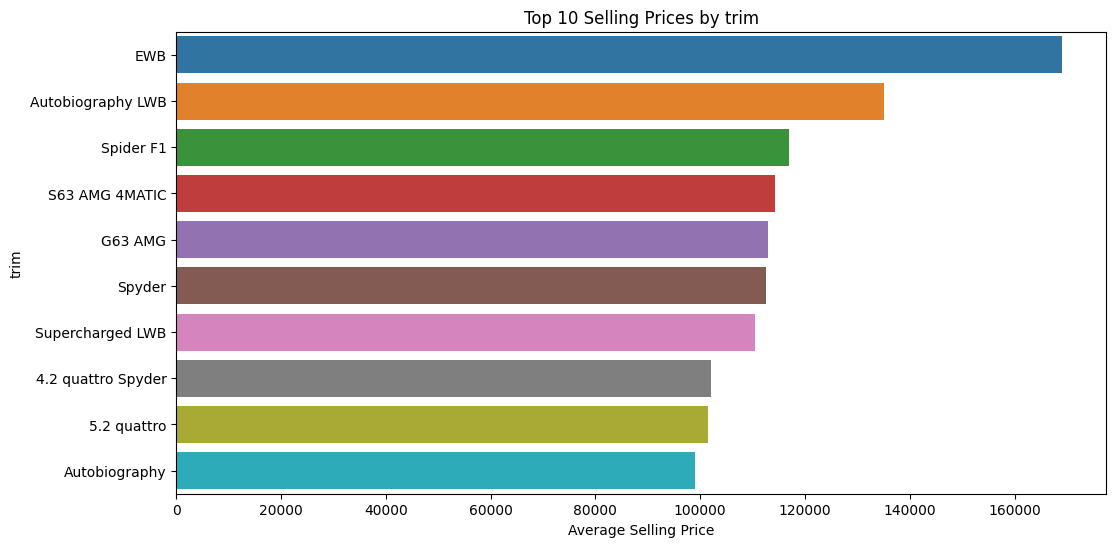

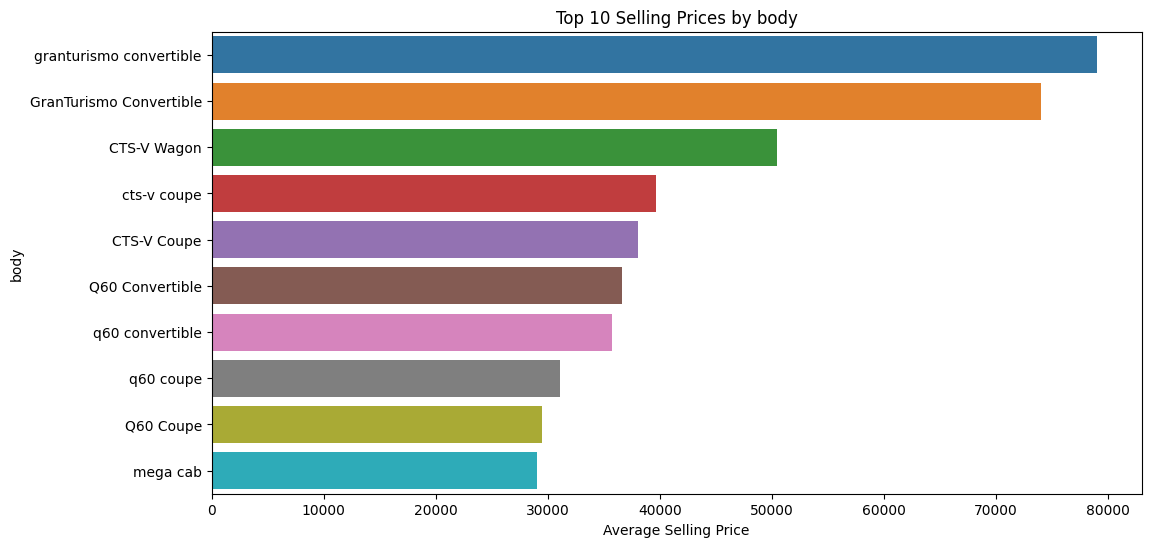

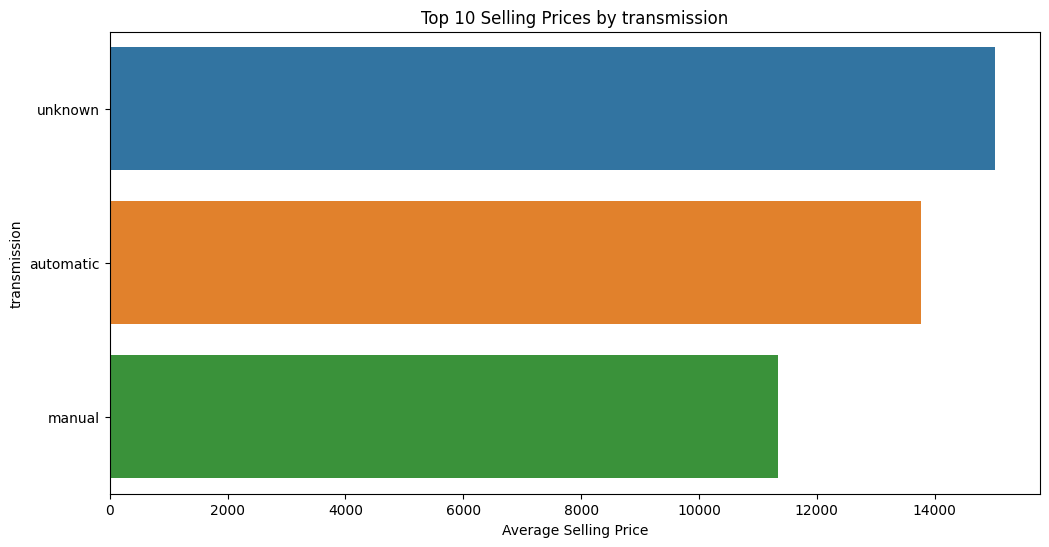

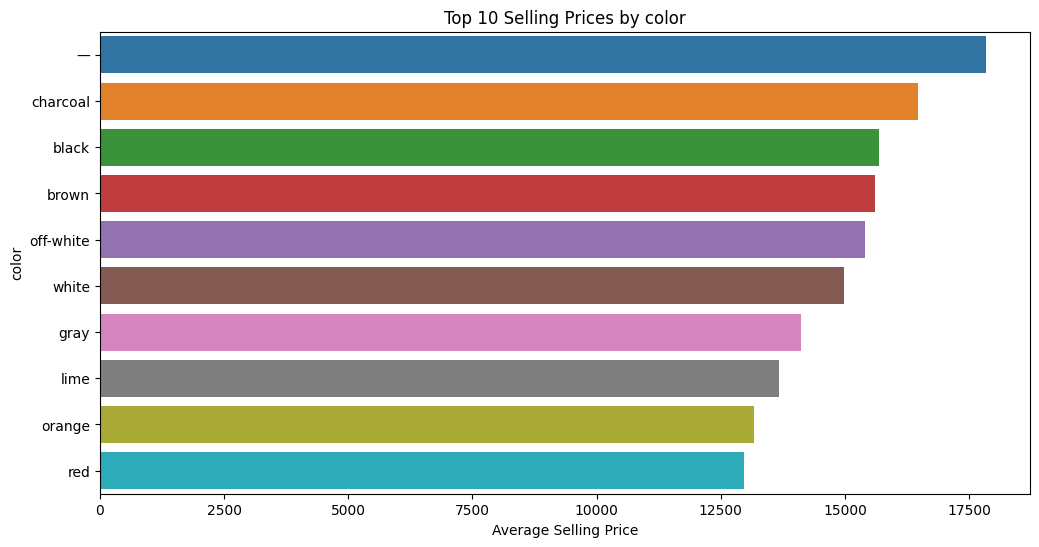

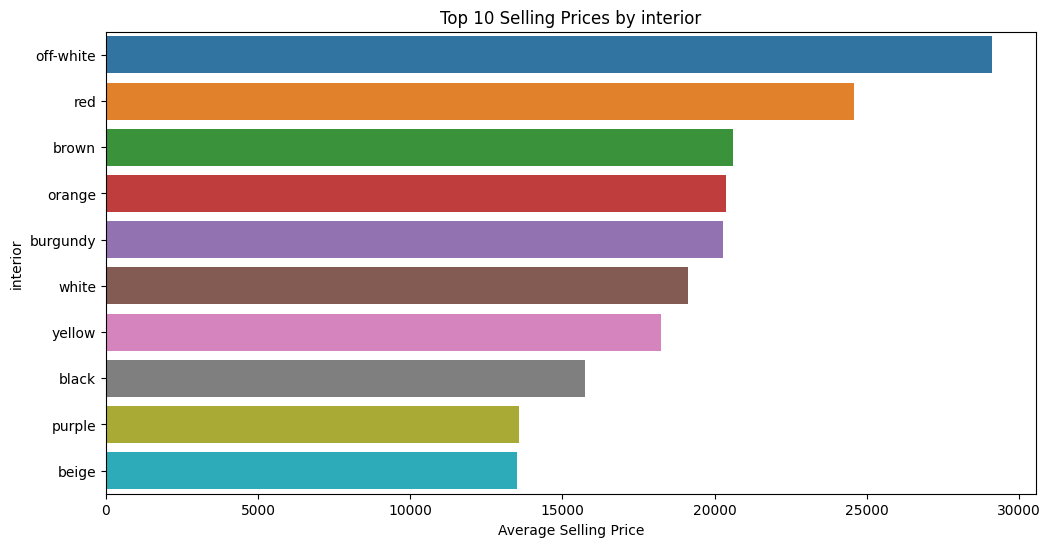

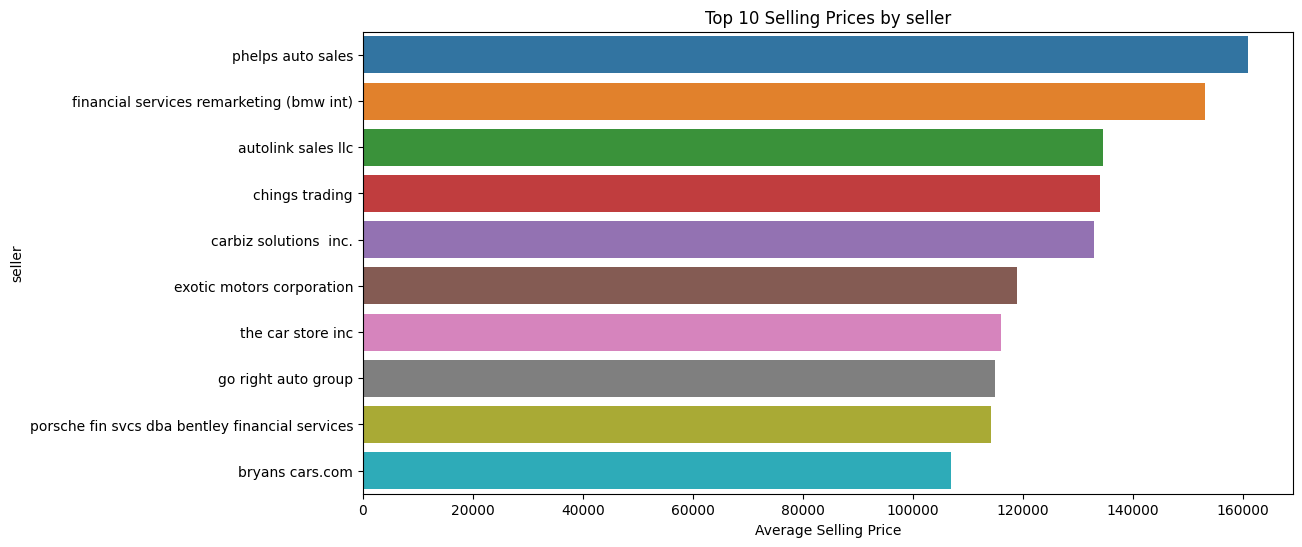

In [21]:
# Plot the Top 10 Selling Prices for each categorical columns
categorical_cols = ['make', 'model', 'trim', 'body', 'transmission', 'color', 'interior', 'seller']

for col in categorical_cols:
    plot_top_selling_prices(cars_df, col)

Top 10 selling prices by make:
- Can identify which car brands command higher prices in the market

Top 10 selling prices by model:
- Identify popular car models
- Prioritise marketing efforts for high-performing models

Top 10 selling prices by trim
- Identify which trim levels are most sought after by consumers and assess the impact of features and specifications on pricing.

Top 10 selling prices by Seller Types
- Understand the influence of seller channels on pricing. 
- Inform partnership decisions with sellers and pricing strategies for different distribution channels.